<a href="https://colab.research.google.com/github/famousahmet/retail-revenue-decomposition-model/blob/main/notebooks/model1_abv_transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Raw Data ===


,date,transactions,abv,promo,discount_rate
0,2024-01-01,120,18.30,0,0.00
1,2024-01-02,140,17.10,1,0.10
2,2024-01-03,95,19.80,0,0.00
3,2024-01-04,160,16.50,1,0.15
4,2024-01-05,175,16.90,1,0.05



=== ABV Regression Summary ===
                            OLS Regression Results                            
Dep. Variable:                    abv   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     5.694
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.297
Time:                        13:13:58   Log-Likelihood:               -0.77159
No. Observations:                   5   AIC:                             9.543
Df Residuals:                       1   BIC:                             7.981
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


,date,transactions,abv,revenue,delta_T,delta_ABV,delta_rev,rev_from_T,rev_from_ABV
0,2024-01-01,120,18.30,"2,196.00",NaN,NaN,NaN,NaN,NaN
1,2024-01-02,140,17.10,"2,394.00",20.00,-1.20,198.00,366.00,-168.00
2,2024-01-03,95,19.80,"1,881.00",-45.00,2.70,-513.00,-769.50,256.50
3,2024-01-04,160,16.50,"2,640.00",65.00,-3.30,759.00,"1,287.00",-528.00
4,2024-01-05,175,16.90,"2,957.50",15.00,0.40,317.50,247.50,70.00



=== FP&A Revenue Bridge Summary ===
Total ΔRevenue:        761.50
Explained by ΔT:       1,131.00
Explained by ΔABV:     -369.50
Check (ΔT + ΔABV):     761.50
Difference vs Actual:  -0.0000

=== Contribution Share ===
ΔT (volume effect): 148.5%
ΔABV (value effect): -48.5%


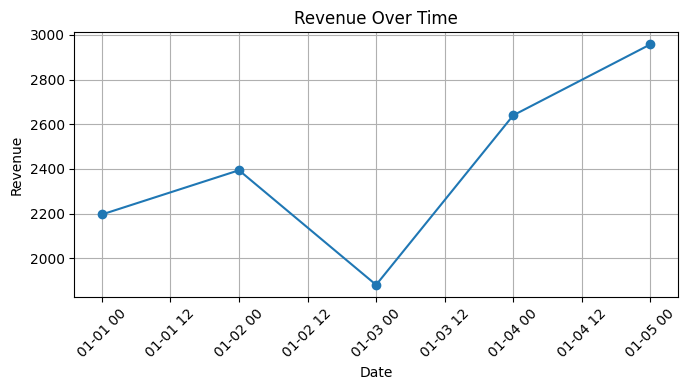

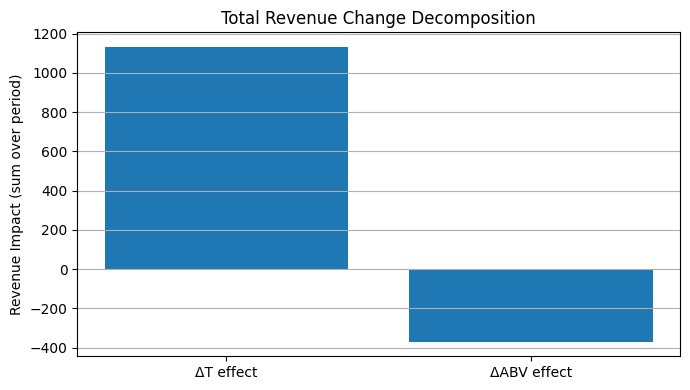


=== FP&A-style Narrative ===
Over the observed period, total revenue changed by 761.50.
Approximately 148.5% of this change is driven by changes in Transactions (customer traffic), while -48.5% is driven by changes in Average Basket Value (ABV).
Discount elasticity (alpha) is estimated at 8.791, meaning that a 10 percentage point increase in discount rate is associated with an approximate change of 0.88 units in ABV, holding other factors constant.

Model 1 – ABV × Transactions revenue decomposition is fully executed in this single cell.


In [1]:
# ============================================
# MODEL 1 – Retail Revenue Decomposition
# ABV × Transactions + Discount Elasticity
# Tek hücrelik Colab/Notebook versiyonu
# ============================================

# Gerekli kütüphaneler
import sys

try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
except ImportError:
    !pip install pandas numpy matplotlib statsmodels
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.api as sm

pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

# --------------------------------------------
# 1) Örnek veri seti (Demo amaçlı)
#    İstersen bunu dış CSV ile değiştirebilirsin
# --------------------------------------------
data = {
    "date": ["2024-01-01","2024-01-02","2024-01-03","2024-01-04","2024-01-05"],
    "transactions": [120, 140, 95, 160, 175],
    "abv":          [18.3, 17.1, 19.8, 16.5, 16.9],
    "promo":        [0,    1,    0,    1,    1],
    "discount_rate":[0.00, 0.10, 0.00, 0.15, 0.05]
}

df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])

print("=== Raw Data ===")
display(df)

# --------------------------------------------
# 2) ABV Regresyon Modeli
#    ABV ~ Promo + DiscountRate + Transactions
# --------------------------------------------
X = df[["promo", "discount_rate", "transactions"]]
X = sm.add_constant(X)  # β0 için
y = df["abv"]

model = sm.OLS(y, X).fit()

print("\n=== ABV Regression Summary ===")
print(model.summary())

# --------------------------------------------
# 3) Discount Elasticity (α) Hesabı
#    ABV = ABV_normal − α × DiscountRate
# --------------------------------------------
if "discount_rate" in model.params.index:
    alpha = -model.params["discount_rate"]
else:
    alpha = np.nan

print("\n=== Discount Elasticity (alpha) ===")
print(f"Estimated alpha: {alpha:,.4f}")
if not np.isnan(alpha):
    print(f"Interpretation: For a 10 percentage point increase in discount rate, "
          f"ABV is expected to change by approximately {alpha * 0.10:,.2f} units (ceteris paribus).")

# --------------------------------------------
# 4) Revenue Hesabı ve Decomposition
#    Revenue = Transactions × ABV
#    ΔRevenue = ΔT × ABV_prev  +  ΔABV × T_new
# --------------------------------------------
df["revenue"] = df["transactions"] * df["abv"]

df = df.sort_values("date")  # tarih sırası garanti olsun

df["delta_T"]   = df["transactions"].diff()
df["delta_ABV"] = df["abv"].diff()
df["delta_rev"] = df["revenue"].diff()

df["rev_from_T"]   = df["delta_T"] * df["abv"].shift(1)
df["rev_from_ABV"] = df["delta_ABV"] * df["transactions"]

print("\n=== Decomposition Table (first rows) ===")
display(df[["date","transactions","abv","revenue",
            "delta_T","delta_ABV","delta_rev",
            "rev_from_T","rev_from_ABV"]])

# --------------------------------------------
# 5) Toplam Etki – FP&A Revenue Bridge Özeti
# --------------------------------------------
mask = df["delta_rev"].notna()

total_delta = df.loc[mask, "delta_rev"].sum()
total_T     = df.loc[mask, "rev_from_T"].sum()
total_ABV   = df.loc[mask, "rev_from_ABV"].sum()

print("\n=== FP&A Revenue Bridge Summary ===")
print(f"Total ΔRevenue:        {total_delta:,.2f}")
print(f"Explained by ΔT:       {total_T:,.2f}")
print(f"Explained by ΔABV:     {total_ABV:,.2f}")
print(f"Check (ΔT + ΔABV):     {(total_T + total_ABV):,.2f}")
print(f"Difference vs Actual:  {(total_delta - (total_T + total_ABV)):,.4f}")

if total_delta != 0:
    pct_T   = total_T   / total_delta * 100
    pct_ABV = total_ABV / total_delta * 100
else:
    pct_T = pct_ABV = np.nan

print("\n=== Contribution Share ===")
print(f"ΔT (volume effect): {pct_T:,.1f}%")
print(f"ΔABV (value effect): {pct_ABV:,.1f}%")

# --------------------------------------------
# 6) Basit Grafikler
# --------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(df["date"], df["revenue"], marker="o")
plt.title("Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.bar(["ΔT effect","ΔABV effect"], [total_T, total_ABV])
plt.title("Total Revenue Change Decomposition")
plt.ylabel("Revenue Impact (sum over period)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# --------------------------------------------
# 7) Mini FP&A Yorum Metni (print)
# --------------------------------------------
print("\n=== FP&A-style Narrative ===")
print(f"Over the observed period, total revenue changed by {total_delta:,.2f}.")
print(f"Approximately {pct_T:,.1f}% of this change is driven by changes in "
      f"Transactions (customer traffic), while {pct_ABV:,.1f}% is driven by "
      f"changes in Average Basket Value (ABV).")
if not np.isnan(alpha):
    print(f"Discount elasticity (alpha) is estimated at {alpha:,.3f}, meaning that "
          f"a 10 percentage point increase in discount rate is associated with an "
          f"approximate change of {alpha * 0.10:,.2f} units in ABV, holding other "
          f"factors constant.")
print("\nModel 1 – ABV × Transactions revenue decomposition is fully executed in this single cell.")


In [2]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1tClZZnNLb42B4UQvoeCkwOett5eHnMYXB-LPntHVRlo/edit#gid=0
